# Preparando Dados

In [157]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 772.0/772.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for scikit-surprise: started
  Running setup.py install for scikit-surprise: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: scikit-surprise is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [163]:
import pandas as pd

from itertools import chain
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from surprise import Dataset
from surprise import Reader

In [164]:
movies = pd.read_csv('./datasets/movies.csv', encoding='utf-8')
ratings = pd.read_csv('./datasets/ratings.csv', encoding='utf-8')
# tags = pd.read_csv('./datasets/tags.csv', encoding='utf-8')

In [165]:
data = pd.merge(movies, ratings, on="movieId")
data = data.drop(["timestamp"], axis=1)

data['genres'] = data['genres'].str.split('|')

data.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5


In [166]:
min_rating = data["rating"].min()
max_rating = data["rating"].max()

print(f"Max movie rating: {max_rating}")
print(f"Min movie rating: {min_rating}")

Max movie rating: 5.0
Min movie rating: 0.5


In [167]:
# Divide o dataset em treino e teste
train_data, test_data = train_test_split(data, test_size=0.10, random_state=42)

# Exibe o número de amostras em cada parte
print("Number of samples in the training set:", len(train_data))
print("Number of samples in the test set:", len(test_data))


Number of samples in the training set: 90752
Number of samples in the test set: 10084


In [168]:
print(f'Total unique movies: {len(data["movieId"].unique())}')
print(f'Total unique user: {len(data["userId"].unique())}')

ratings.head()

Total unique movies: 9724
Total unique user: 610


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [169]:
user_1 = data.loc[data['userId'] == 1]

user_1.head(300)  

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0
325,3,Grumpier Old Men (1995),"[Comedy, Romance]",1,4.0
433,6,Heat (1995),"[Action, Crime, Thriller]",1,4.0
2107,47,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",1,5.0
2379,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",1,5.0
...,...,...,...,...,...
56816,3744,Shaft (2000),"[Action, Crime, Thriller]",1,4.0
57276,3793,X-Men (2000),"[Action, Adventure, Sci-Fi]",1,5.0
57457,3809,What About Bob? (1991),[Comedy],1,4.0
59170,4006,Transformers: The Movie (1986),"[Adventure, Animation, Children, Sci-Fi]",1,4.0


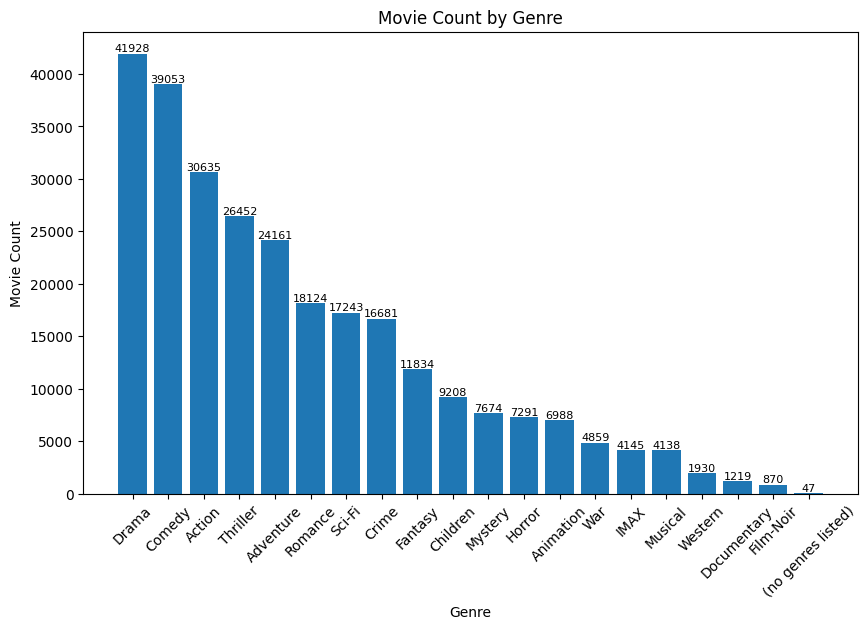

In [170]:
genre_counts = data.explode('genres')['genres'].value_counts().to_dict()

genres = list(genre_counts.keys())
counts = list(genre_counts.values())

plt.figure(figsize=(10, 6))  # Define o tamanho da figura
bars = plt.bar(genres, counts)  # Cria o gráfico de barras
plt.xlabel('Genre')  # Define o rótulo do eixo x
plt.ylabel('Movie Count')  # Define o rótulo do eixo y
plt.title('Movie Count by Genre')  # Define o título do gráfico
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x em 45 graus

# Adiciona os valores das colunas acima delas com tamanho de fonte reduzido
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, yval, ha='center', va='bottom', fontsize=8)

plt.show()  # Exibe o gráfico

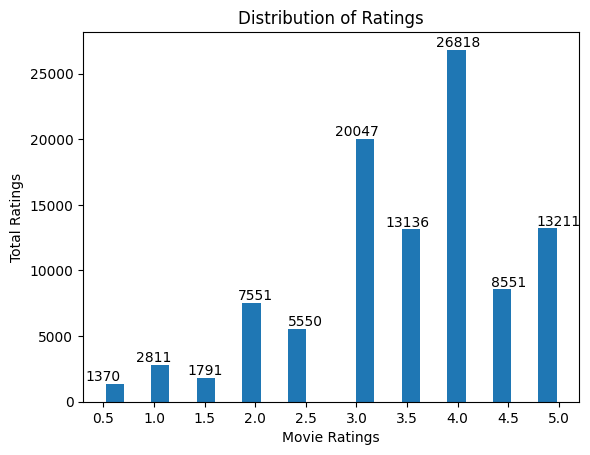

In [174]:
plt.hist(data['rating'], bins=20, rwidth=0.8)

plt.xlabel('Movie Ratings')
plt.ylabel('Total Ratings')
plt.title('Distribution of Ratings')

value_counts = data['rating'].value_counts()

unique_values = value_counts.index
ticks = [value for value in unique_values if value_counts[value] > 0]
plt.xticks(ticks)

for value in unique_values:
    count = value_counts[value]
    if count > 0:
        plt.text(value, count, str(count), ha='center', va='bottom')

plt.show()
